In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 31.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488498 sha256=5454f8a8f650de02675cdb75639afc4bfb7161648d4db3174eaa531f96815426
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

In [ ]:
import pyspark
sc=spark.sparkContext
from pyspark.sql import functions as f
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [ ]:
names= spark.read.csv("/Volumes/project_csv/default/for_project_data/name_data.tsv",sep='\t', header=True, inferSchema=True)
basics=spark.read.csv("/Volumes/project_csv/default/for_project_data/title_basics_data.tsv",sep='\t',header=True, inferSchema=True)
principals=spark.read.csv("/Volumes/project_csv/default/for_project_data/title_principalsdata.tsv",sep='\t',header=True, inferSchema=True)

In [ ]:
names.createOrReplaceTempView("names")
basics.createOrReplaceTempView("basics")
principals.createOrReplaceTempView("principals")

In [ ]:
#EXPLORATORY ANALYSIS
names.show(n=5, truncate=False)
actors=names.filter((f.array_contains(f.array(names.primaryProfession),"actor"))|(f.array_contains(f.array(names.primaryProfession),"actress")))
actors.show(n=10,truncate=False)
actors.select('primaryName').distinct().show()
actors.select('nconst').distinct().count()


+---------+---------------+---------+---------+-----------------------------------+---------------------------------------+
|nconst   |primaryName    |birthYear|deathYear|primaryProfession                  |knownForTitles                         |
+---------+---------------+---------+---------+-----------------------------------+---------------------------------------+
|nm0000001|Fred Astaire   |1899     |1987     |soundtrack,actor,miscellaneous     |tt0053137,tt0072308,tt0050419,tt0027125|
|nm0000002|Lauren Bacall  |1924     |2014     |actress,soundtrack                 |tt0038355,tt0037382,tt0117057,tt0075213|
|nm0000003|Brigitte Bardot|1934     |\N       |actress,soundtrack,music_department|tt0057345,tt0054452,tt0049189,tt0056404|
|nm0000004|John Belushi   |1949     |1982     |actor,soundtrack,writer            |tt0077975,tt0080455,tt0072562,tt0078723|
|nm0000005|Ingmar Bergman |1918     |2007     |writer,director,actor              |tt0083922,tt0050976,tt0069467,tt0050986|
+-------

3945613

In [ ]:
basics.show(n=5, truncate=False)
basics.select('titleType').distinct().show()
basics_movies=basics.filter(basics.titleType=='movie')
basics_movies.show(n=10,truncate=False)
principals.show(n=5,truncate=False)

+---------+---------+----------------------+----------------------+-------+---------+-------+--------------+------------------------+
|tconst   |titleType|primaryTitle          |originalTitle         |isAdult|startYear|endYear|runtimeMinutes|genres                  |
+---------+---------+----------------------+----------------------+-------+---------+-------+--------------+------------------------+
|tt0000001|short    |Carmencita            |Carmencita            |0      |1894     |\N     |1             |Documentary,Short       |
|tt0000002|short    |Le clown et ses chiens|Le clown et ses chiens|0      |1892     |\N     |5             |Animation,Short         |
|tt0000003|short    |Pauvre Pierrot        |Pauvre Pierrot        |0      |1892     |\N     |4             |Animation,Comedy,Romance|
|tt0000004|short    |Un bon bock           |Un bon bock           |0      |1892     |\N     |12            |Animation,Short         |
|tt0000005|short    |Blacksmith Scene      |Blacksmith Scene  

In [ ]:
people= (
    names
    .withColumn("titles_array", f.split("primaryProfession", "\,"))
    .withColumn("primaryProfession", f.explode("titles_array"))
    .select("nconst", "primaryName","primaryProfession")
)
people.createOrReplaceTempView('people')
                               
people.show()

+---------+---------------+-----------------+
|   nconst|    primaryName|primaryProfession|
+---------+---------------+-----------------+
|nm0000001|   Fred Astaire|       soundtrack|
|nm0000001|   Fred Astaire|            actor|
|nm0000001|   Fred Astaire|    miscellaneous|
|nm0000002|  Lauren Bacall|          actress|
|nm0000002|  Lauren Bacall|       soundtrack|
|nm0000003|Brigitte Bardot|          actress|
|nm0000003|Brigitte Bardot|       soundtrack|
|nm0000003|Brigitte Bardot| music_department|
|nm0000004|   John Belushi|            actor|
|nm0000004|   John Belushi|       soundtrack|
|nm0000004|   John Belushi|           writer|
|nm0000005| Ingmar Bergman|           writer|
|nm0000005| Ingmar Bergman|         director|
|nm0000005| Ingmar Bergman|            actor|
|nm0000006| Ingrid Bergman|          actress|
|nm0000006| Ingrid Bergman|       soundtrack|
|nm0000006| Ingrid Bergman|         producer|
|nm0000007|Humphrey Bogart|            actor|
|nm0000007|Humphrey Bogart|       

In [ ]:
query = """SELECT  primaryProfession AS profession, COUNT(*) AS people
           FROM people
           GROUP BY primaryProfession
           ORDER BY people DESC 
           """
people = spark.sql(query)
people.show()

+--------------------+-------+
|          profession| people|
+--------------------+-------+
|               actor|3077026|
|             actress|1862170|
|       miscellaneous|1384023|
|            producer|1175607|
|              writer| 875522|
|   camera_department| 787069|
|            director| 715927|
|      art_department| 471229|
|    sound_department| 385643|
|     cinematographer| 381920|
|              editor| 354083|
|            composer| 329845|
|    music_department| 267557|
|  assistant_director| 257709|
|      visual_effects| 237854|
|  make_up_department| 225037|
|animation_department| 216061|
|  production_manager| 208125|
|editorial_department| 188440|
|          soundtrack| 171142|
+--------------------+-------+
only showing top 20 rows



In [ ]:
people=people.toPandas()
people = people.set_index("profession")
people

,people
profession,
actor,3077026
actress,1862170
miscellaneous,1384023
producer,1175607
writer,875522
camera_department,787069
director,715927
art_department,471229
sound_department,385643


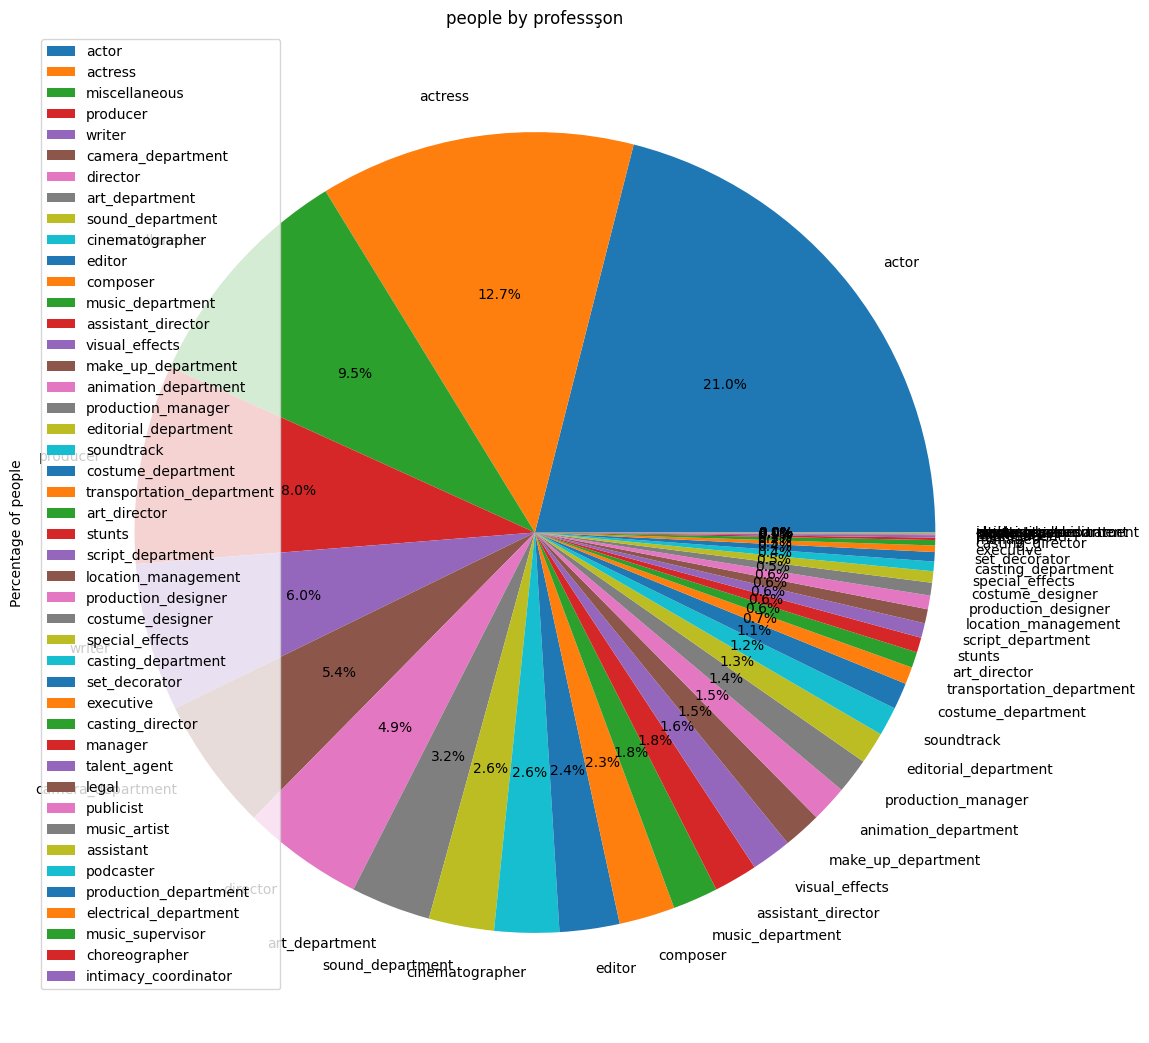

In [ ]:
pie = people.plot.pie(y = "people", figsize = (13,13), autopct = "%1.1f%%")
pie.legend(loc = "upper left");
pie.set(title = "people by professşon", ylabel = "Percentage of people");

In [ ]:
movies=basics_movies.join(principals,basics_movies.tconst==principals.tconst).select(principals.tconst,basics_movies.primaryTitle,principals.nconst)

movies.show(n=10,truncate=False)

movies=movies.join(names,movies.nconst==names.nconst,"left").select(movies.tconst,movies.primaryTitle,movies.nconst,names.primaryName)
movies.cache()

movies.createOrReplaceTempView('movies')

movies.show(n=10,truncate=False)

+---------+-----------------------------+---------+
|tconst   |primaryTitle                 |nconst   |
+---------+-----------------------------+---------+
|tt0000009|Miss Jerry                   |nm0063086|
|tt0000009|Miss Jerry                   |nm0183823|
|tt0000009|Miss Jerry                   |nm1309758|
|tt0000009|Miss Jerry                   |nm0085156|
|tt0000147|The Corbett-Fitzsimmons Fight|nm0179163|
|tt0000147|The Corbett-Fitzsimmons Fight|nm0280615|
|tt0000147|The Corbett-Fitzsimmons Fight|nm4082222|
|tt0000147|The Corbett-Fitzsimmons Fight|nm4081458|
|tt0000147|The Corbett-Fitzsimmons Fight|nm0714557|
|tt0000147|The Corbett-Fitzsimmons Fight|nm0103755|
+---------+-----------------------------+---------+
only showing top 10 rows

+----------+---------------------+----------+-------------------+
|tconst    |primaryTitle         |nconst    |primaryName        |
+----------+---------------------+----------+-------------------+
|tt2071521 |Love Song            |nm1295740 |Mar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 15.3 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
(4743628, 4)
+----------+--------------------+
|    tconst|              actors|
+----------+--------------------+
| tt1165287|[nm0046000, nm255...|
| tt1188990|[nm2929537, nm294...|
|tt12094140|[nm1938492, nm114...|
|tt12099366|[nm0650394, nm577...|
| tt1223461|[nm9119701, nm117...|
|tt12247534|[nm11545741, nm11...|
| tt1463170|[nm0619309, nm116...|
|tt14722156|[nm3804902, nm046...|
| tt1529572|[nm0275284, nm033...|
|tt17912040|[nm0589569, nm864...|
|tt19815058|[nm10545410, nm91...|
| tt1613703|[nm2380781, nm236...|
| tt1638000|[nm1081076, nm067...|
|tt16756384|[nm8924658, nm134...|
| tt1714151|[nm4043195, nm423...|
| tt2099693|[nm4778757, nm478...|
|tt21302422|[nm13854858, nm38...|
|tt26615197|[nm5518673, nm592...|
|tt26751054|[nm12052336, nm12...|
| tt2746062|[nm1266291, nm441...|
+----------+----

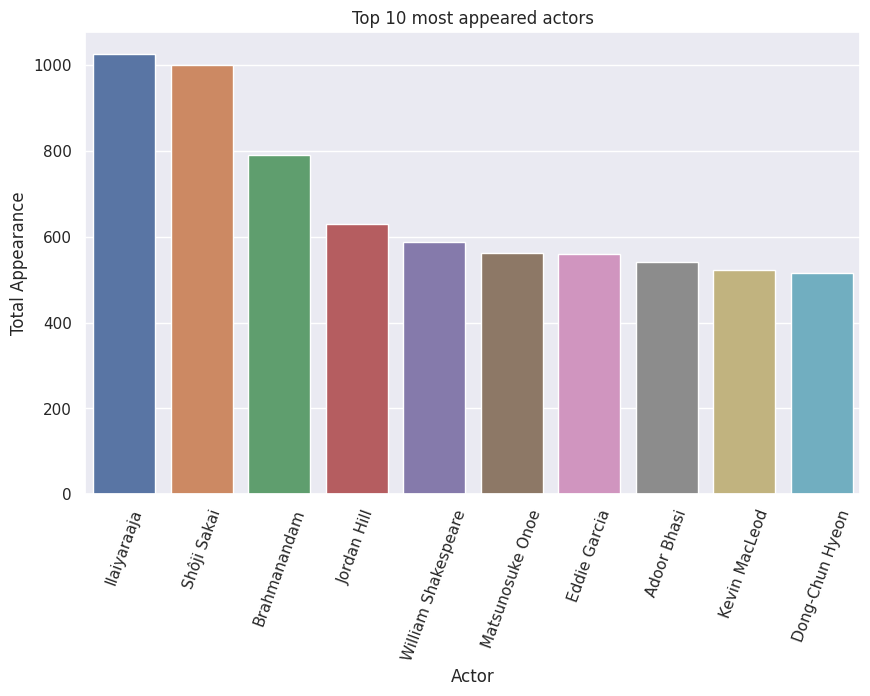

In [ ]:
!pip install wordcloud
import seaborn as sns
from wordcloud import WordCloud


query = """SELECT primaryName, COUNT(*) AS actor_count
           FROM movies
           GROUP BY primaryName
           ORDER BY actor_count desc
           LIMIT 10"""
appearance = spark.sql(query)
sns.set(rc={'figure.figsize':(10,6)})
ax = sns.barplot(x = "primaryName", y = "actor_count", data = appearance.toPandas())
ax.set(title = "Top 10 most appeared actors", xlabel = "Actor", ylabel = "Total Appearance")
ax.set_xticklabels(ax.get_xticklabels(), rotation=70);

Dict_ = {col:movies.filter(movies[col].isNull()).count() for col in movies.columns}
Dict_

Dict_ = {col:movies.filter(movies[col]=='\\N').count() for col in movies.columns}
Dict_

Dict_ = {col:movies.filter(movies[col]==' ').count() for col in movies.columns}
Dict_


print((movies.count(), len(movies.columns)))

movie_baskets=movies.groupBy('tconst').agg(f.collect_set('nconst').alias('actors'))

movie_baskets.show()

movie_baskets.printSchema()

movie_baskets.cache()

print(movie_baskets.count(), len(movie_baskets.columns))

basket_sizes=movie_baskets.withColumn("size", f.size("actors")).select('*')
basket_sizes.sort('size',ascending=False).show()

basket_sizes.groupBy('size').count().sort('count',ascending=False).show()

actor_movie_numbers=movies.groupBy('nconst').agg(f.collect_set('tconst').alias('movie_titles')).withColumn("size", f.size("movie_titles")).select('*').sort('size',ascending=False)

actor_movie_numbers.groupby('size').count().sort('count',ascending=False).show()

In [ ]:
#FPGrowth
from pyspark.ml.fpm import FPGrowth
movie_baskets.toPandas().head(5)
import time
start_time = time.time()
fpGrowth = FPGrowth(itemsCol="actors", minSupport=0.0004, minConfidence=0)
model = fpGrowth.fit(movie_baskets)
model.freqItemsets.show(truncate=False)
end_time = time.time()
print('Duration: {}'.format(end_time - start_time))



+-----------+----+
|items      |freq|
+-----------+----+
|[nm0006137]|1024|
|[nm0756966]|1001|
|[nm0103977]|790 |
|[nm6665663]|620 |
|[nm0000636]|587 |
|[nm0648803]|563 |
|[nm0305182]|555 |
|[nm0006982]|541 |
|[nm1930572]|523 |
|[nm0232490]|515 |
|[nm0453459]|512 |
|[nm0706691]|479 |
|[nm0481568]|477 |
|[nm0473742]|471 |
|[nm0644554]|446 |
|[nm0619107]|427 |
|[nm0246703]|413 |
|[nm0183659]|411 |
|[nm0793813]|408 |
|[nm0156963]|405 |
+-----------+----+
only showing top 20 rows

Duration: 5.536484241485596


In [ ]:
# Display frequent itemsets.
mostPopularActorInABasket = model.freqItemsets
mostPopularActorInABasket.createOrReplaceTempView("mostPopularActorInABasket")
mostPopularActorInABasket.sort('freq', ascending=False).show(truncate=False)

# Display generated association rules.
associationRules = model.associationRules
associationRules.createOrReplaceTempView("associationRules")
associationRules.sort('confidence', ascending=False).show(truncate=False)

# transform examines the input items against all the association rules and summarize the consequents as prediction
associations = model.transform(movie_baskets)
associations.sort('prediction', ascending=False).show(truncate=False)

#Most frequent basket of items (containing at least 2 items)

query = """select items, freq
           from mostPopularActorInABasket
           where size(items) > 1
           order by freq desc
           limit 20"""
spark.sql(query).show(truncate=False)

#Association rules
query = """select antecedent as `antecedent (if)`, consequent as `consequent (then)`, confidence
           from associationRules
           order by confidence desc
           limit 20"""

spark.sql(query).show(truncate=False)

+-----------+----+
|items      |freq|
+-----------+----+
|[nm0006137]|1024|
|[nm0756966]|1001|
|[nm0103977]|790 |
|[nm6665663]|620 |
|[nm0000636]|587 |
|[nm0648803]|563 |
|[nm0305182]|555 |
|[nm0006982]|541 |
|[nm1930572]|523 |
|[nm0232490]|515 |
|[nm0453459]|512 |
|[nm0706691]|479 |
|[nm0481568]|477 |
|[nm0473742]|471 |
|[nm0644554]|446 |
|[nm0619107]|427 |
|[nm0246703]|413 |
|[nm0183659]|411 |
|[nm0793813]|408 |
|[nm0156963]|405 |
+-----------+----+
only showing top 20 rows

+------------+------------+------------------+------------------+--------------------+
|antecedent  |consequent  |confidence        |lift              |support             |
+------------+------------+------------------+------------------+--------------------+
|[nm0701403] |[nm0473742] |1.0               |1393.0254777070065|5.974562386167059E-4|
|[nm11785575]|[nm6665663] |0.8986666666666666|951.0139999999999 |5.136294704434436E-4|
|[nm0473742] |[nm0701403] |0.832271762208068 |1393.0254777070063|5.974562386167059E